In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [2]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import jax
jax.config.update('jax_platform_name', 'cpu')

platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)

Platform:  cpu


In [3]:
len(jax.devices())

28

In [4]:
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from pathlib import Path
from omegaconf import OmegaConf

In [5]:
def load_results(paths, ovs_sel, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    obs_vars = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if ovs_sel is not None:
            if obs_var in ovs_sel:
                obs_vars.append(obs_var)

    ovs = jnp.array(obs_vars)
    if ovs.size == jnp.unique(ovs).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            obs_var = cfg.obs.ov2

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[obs_var] = res

    else:
        print('Duplicates found for obs_var - returning empty dict.')

    return results

def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.latent.L == L:
                if cfg.model.emiters == emiters:
                    if cfg.model.init == init:
                        if cfg.model.scale_init == scale_init:
                            if supp is not None:
                                if 'support' in list(cfg.model.keys()):
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
                            else:
                                if 'support' not in list(cfg.model.keys()):
                                    if cfg.model.emiters == emiters:
                                        sel_paths.append(exp)
                                else:
                                    if cfg.model.support == supp:
                                            sel_paths.append(exp)
    return sel_paths

### Data setup

In [6]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

gamma_load = pickle_open(f'gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

We'll want to use the same seed here as we used in the batch runs, so let's load that and simulate latent / observations

We'll use the following observation variance for now, but plan to look at others in the next notebook.

In [7]:
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

- For this observation variance (1e-1):
    - Simulate observations (using Jax lib)
    - Choose $\Gamma^{(r)}$ for EM step $r+1$ 
        - flat / true / intermediate
    - For Jax vs Old:
        - Look at cost/grad/hess at first and last step of optimization in E-Step
            - Note:
                - Recall thet optimization always starts at origin
                - Can profile cost/grad/hess throughout optimization later if bug still not found
        - Check cost/grad/hess at true zs


In [8]:
scale_init = 10
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [9]:
cfg = res_load[ov2]['cfg']
lcfg = cfg.latent
ocfg = cfg.obs

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

L = 25
zs = sample_from_gamma(lrk, gamma_full, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)


Visualizing the simulated data:

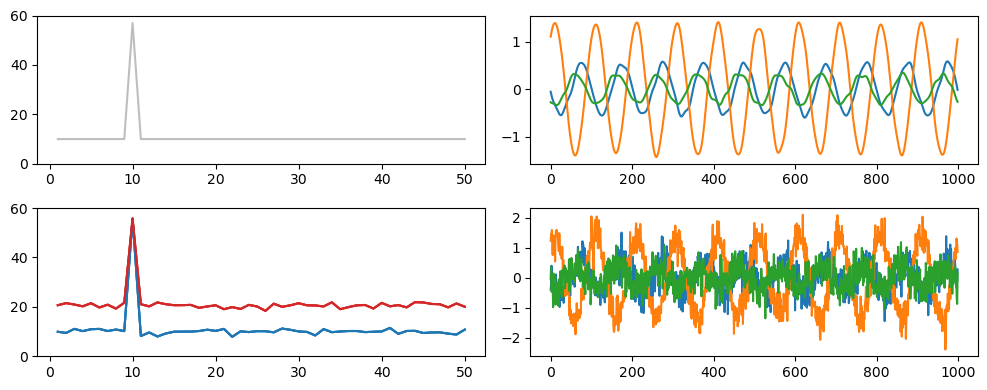

In [10]:
oracle_est = jnp.einsum('jkl,jil->jkil', zs, zs.conj()).mean(-1)
obs_f = jnp.fft.rfft(obs, axis=0)
zs_naive = obs_f[1:,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

dB = True
fig, ax = plt.subplots(2,2,figsize=(10,4))
S_true = gamma_full[nz,0,0].real
S_oracle = oracle_est[nz,0,0].real
S_naive = naive_est[nz,0,0].real
# ax[1,0].plot(S_true, color='tab:grey', alpha=0.5)

if dB == True:
    S_true = 10*jnp.log10(S_true+1e-15)
    S_oracle = 10*jnp.log10(S_oracle+1e-15)
    S_naive = 10*jnp.log10(S_naive+1e-15)

ax[0,0].plot(freqs[nz], S_true, color='tab:grey', alpha=0.5)
for l in range(3):
    ax[1,0].plot(freqs[nz], S_oracle, color='tab:blue')
    ax[1,0].plot(freqs[nz], S_naive, color='tab:red')
    ax[0,1].plot(xs[:,0,l])
    ax[1,1].plot(obs[:,0,l])
ax[0,0].set_ylim([0,60])
ax[1,0].set_ylim([0,60])
plt.tight_layout()

### Setting things up for both Jax / Old models


##### Jax model 

##### Old model setup

In [11]:
def conv_grad_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

conv_mus_old_r2c = conv_grad_old_r2c


In [12]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']

Next:
- Pick a $\Gamma^{(r)}$

- initialize the Jax/Old Models 

- investigate cost/grad/hess behavior 

In [13]:
from cohlib.alg.em_sgc import construct_Gamma_full_real, deconstruct_Gamma_full_real
from cohlib.jax.gaussian_obs import get_e_step_cost_func
from cohlib.alg.laplace_gaussian_obs import TrialDataGaussian, GaussianTrial
from cohlib.utils import conv_z_to_v, conv_v_to_z

In [14]:
def jax_inspect_optim(data, zs, gamma_inv, params):
    cost_func_jax = get_e_step_cost_func(data, gamma_inv, params)
    cost_grad_jax = jax.grad(cost_func_jax, holomorphic=True)
    cost_hess_jax = jax.hessian(cost_func_jax, holomorphic=True)

    cost_jax = cost_func_jax(zs)
    grad_jax = cost_grad_jax(zs).conj()
    hess_jax = cost_hess_jax(zs)
    hess_jax_sel = jnp.stack([hess_jax[n,:,n,:] for n in range(Nnz)])

    res = {'cost': cost_jax, 'grad': grad_jax, 'hess': hess_jax_sel}
    return res

def old_inspect_optim(data, zs, gamma_inv, params, return_type='complex'):
    K = data.shape[1]
    obs_var = params['obs_var']
    nz = params['nonzero_inds']
    Wv = params['Wv']
    sample_length = Wv.shape[0]
    num_J_vars = Wv.shape[1]

    invQ = jnp.diag(jnp.ones(sample_length)*(1/obs_var))

    obs_objs = [GaussianTrial(data[None,:,i], invQ) for i in range(K)] 
    gamma_inv_oldformat = construct_Gamma_full_real(gamma_inv[nz,:,:], K, num_J_vars, invert=False)
    trial_obj = TrialDataGaussian(obs_objs, gamma_inv_oldformat, Wv)


    cost_func_old = trial_obj.cost_func()
    cost_grad_old = trial_obj.cost_grad()
    cost_hess_old = trial_obj.cost_hess()

    vs = conv_z_to_v(zs, axis=0)
    vs_flat = jnp.concatenate([vs[:,k] for k in range(K)])

    cost_old_real = cost_func_old(vs_flat)
    grad_old_real = cost_grad_old(vs_flat)
    hess_old_full_real = cost_hess_old(vs_flat)

    if return_type == 'complex':
        grad_old = conv_grad_old_r2c(grad_old_real, K)
        hess_old = deconstruct_Gamma_full_real(hess_old_full_real, K, num_J_vars)
        res = {'cost': cost_old_real, 'grad': grad_old, 'hess': hess_old}
    else:
        res = {'cost': cost_old_real, 'grad': grad_old_real, 'hess': hess_old_full_real}

    return res

In [142]:
class OptimResult():
    def __init__(self, zs_est, hess, track_zs=None, track_cost=None, track_grad=None, track_hess=None):
        self.zs_est = zs_est
        self.hess = hess
        self.track_zs = track_zs
        self.track_cost = track_cost
        self.track_grad = track_grad
        self.track_hess = track_hess

class JaxOptim():
    def __init__(self, data, gamma_inv, params, track=False):
        self.data = data
        self.gamma_inv = gamma_inv
        self.params = params
        self.nz = params['nonzero_inds']
        self.Nnz = self.nz.size
        self.track = track
        
        self.cost_func = get_e_step_cost_func(data, gamma_inv, params)
        self.cost_grad = jax.grad(self.cost_func, holomorphic=True)
        self.cost_hess = jax.hessian(self.cost_func, holomorphic=True)        

    def eval_cost(self, zs):
        cost = self.cost_func(zs)
        grad = self.cost_grad(zs)
        hess = self.cost_hess(zs)
        hess_sel = jnp.stack([hess[n,:,n,:] for n in range(self.Nnz)])

        return cost, grad.conj(), hess_sel

    def run_e_step(self, zs_init, num_iters):
        zs_est = zs_init
        if self.track is True:
            track_zs = [zs_init]
            track_cost = []
            track_grad = []
            track_hess = []

        for _ in range(num_iters):
            cost, grad, hess = self.eval_cost(zs_est)
            hess_inv = jnp.linalg.inv(hess)

            zs_est = zs_est - jnp.einsum('nki,ni->nk', hess_inv, grad)
            if self.track is True:
                track_zs.append(zs_est)
                track_cost.append(cost)
                track_grad.append(grad) 
                track_hess.append(hess) 


        if self.track is True:
            result = OptimResult(zs_est, hess, track_zs, track_cost, track_grad, track_hess)
        else:
            result = OptimResult(zs_est, hess)
        self.result = result

class OldOptim():
    def __init__(self, data, gamma_inv, params, track=False):
        self.data = data
        self.gamma_inv = gamma_inv
        self.params = params
        self.track = track

        self.obs_var = params['obs_var']
        self.Wv = params['Wv']
        self.num_J_vars = self.Wv.shape[1]
        self.K = data.shape[1]

        nz = params['nonzero_inds']
        sample_length = self.Wv.shape[0]

        invQ = jnp.diag(jnp.ones(sample_length)*(1/self.obs_var))

        obs_objs = [GaussianTrial(data[None,:,i], invQ) for i in range(K)] 
        gamma_inv_oldformat = construct_Gamma_full_real(self.gamma_inv[nz,:,:], self.K, self.num_J_vars, invert=False)
        trial_obj = TrialDataGaussian(obs_objs, gamma_inv_oldformat, self.Wv)

        self.cost_func = trial_obj.cost_func()
        self.cost_grad = trial_obj.cost_grad()
        self.cost_hess = trial_obj.cost_hess()

        self.optim_result = None

    def eval_cost(self, zs):
        vs = conv_z_to_v(zs, axis=0)
        vs_flat = jnp.concatenate([vs[:,k] for k in range(self.K)])

        cost_real = self.cost_func(vs_flat)
        grad_real = self.cost_grad(vs_flat)
        hess_full_real = self.cost_hess(vs_flat)

        grad = conv_grad_old_r2c(grad_real, K)
        hess = deconstruct_Gamma_full_real(hess_full_real, self.K, self.num_J_vars)

        return cost_real, grad, hess

    def run_e_step(self, zs_init, num_iters):
        zs_est = zs_init
        if self.track is True:
            track_zs = [zs_init]
            track_cost = []
            track_grad = []
            track_hess = []

        for _ in range(num_iters):
            cost, grad, hess = self.eval_cost(zs_est)
            hess_inv = jnp.linalg.inv(hess)

            zs_est = zs_est - jnp.einsum('nki,ni->nk', hess_inv, grad)
            if self.track is True:
                track_zs.append(zs_est)
                track_cost.append(cost)
                track_grad.append(grad) 
                track_hess.append(hess) 


        if self.track is True:
            result = OptimResult(zs_est, hess, track_zs, track_cost, track_grad, track_hess)
        else:
            result = OptimResult(zs_est, hess)
        self.result = result

class JvOExp():
    def __init__(self, obs, gamma_inv, obs_var, params, method, track=False):
        self.obs = obs
        self.gamma_inv = gamma_inv
        self.params = params
        self.params['obs_var'] = obs_var
        self.method = method
        self.Nnz = params['nonzero_inds'].size
        self.K = obs.shape[1]
        self.track = track
        self.track_data = {}


    def eval_cost(self, trial, zs=None):
        if zs is None:
            zs = jnp.zeros((self.Nnz, self.K), dtype=complex)

        trial_data = self.obs[:,:,trial]
        if self.method == 'jax':
            optimizer = JaxOptim
        elif self.method == 'old':
            optimizer = OldOptim
        else:
            raise ValueError

        optim = optimizer(trial_data, self.gamma_inv, self.params)
        cost, grad, hess = optim.eval_cost(zs)
        return cost, grad, hess

    def e_step(self, num_iters, zs_init=None):
        L = self.obs.shape[-1]


        if zs_init is None:
            Nnz = self.params['nonzero_inds'].size
            K = obs.shape[1]
            zs_init = jnp.zeros((Nnz, K), dtype=complex)

        mus = jnp.zeros((self.Nnz,K,L), dtype=complex)
        Upss = jnp.zeros((self.Nnz,K,K,L), dtype=complex)

        for trial in tqdm(range(L)):
            trial_data = self.obs[:,:,trial]
            if self.method == 'jax':
                optimizer = JaxOptim
            elif self.method == 'old':
                optimizer = OldOptim
            else:
                raise ValueError

            optim = optimizer(trial_data, self.gamma_inv, self.params, self.track)
            optim.run_e_step(zs_init, num_iters)
            if self.track is True:
                self.track_data[trial] = optim.result

            mus = mus.at[:,:,trial].set(optim.result.zs_est)
            Upss = Upss.at[:,:,:,trial].set(optim.result.hess)

        self.mus = mus
        self.Upss = Upss

In [143]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [18]:
from tqdm import tqdm

In [20]:
Nnz = nz.size
nz_target = jnp.array([9])

# gamma_inv_nonzero_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
# gamma_target_inv = jnp.copy(jnp.linalg.inv(gamma_full[nz_target,:,:]))

# gamma_inv_init = jnp.zeros_like((gamma_full))
# gamma_inv_init = gamma_inv_init.at[nz,:,:].set(gamma_inv_nonzero_init)
# gamma_inv_init = gamma_inv_init.at[nz_target,:,:].set(gamma_target_inv)

# gamma_init = jnp.zeros_like(gamma_full)
# gamma_init = gamma_init.at[nz,:,:].set(jnp.linalg.inv(gamma_inv_init[nz,:,:]))

gamma_inv_true = jnp.zeros_like((gamma_full))
gamma_inv_true = gamma_inv_true.at[nz,:,:].set(jnp.linalg.inv(gamma_full[nz,:,:]))

nz_power_init = 10
gamma_inv_flat = jnp.zeros_like((gamma_full))
gamma_inv_flat_nz = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
gamma_inv_flat = gamma_inv_flat.at[nz,:,:].set(gamma_inv_flat_nz)

In [225]:
L = 25
ov1 = 1
ov2 = -3
obs_var = ov1 * 10**ov2

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

params_jax = {'freqs': freqs, 'nonzero_inds': nz}
params_old = {'Wv': Wv, 'nonzero_inds': nz}

# jax_exp = JvOExp(obs, gamma_inv_true, obs_var, params_jax, 'jax')
# old_exp = JvOExp(obs, gamma_inv_true, obs_var, params_old, 'old')
gamma_inv_use = gamma_inv_true
jax_exp = JvOExp(obs, gamma_inv_use, obs_var, params_jax, 'jax')
old_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'old')

jax_exp.e_step(10)
old_exp.e_step(10)

100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


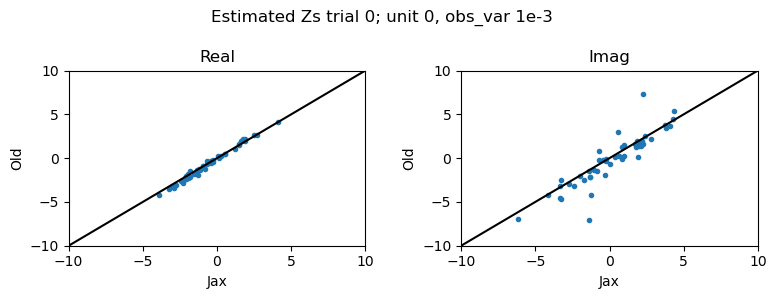

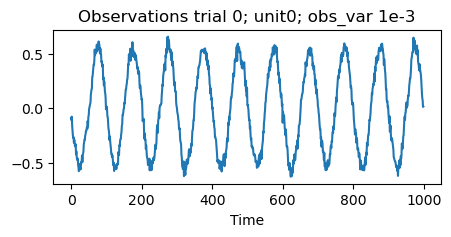

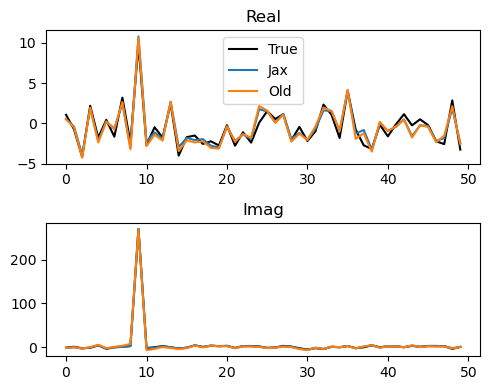

In [226]:
plim = 10
# plim = None
trial = 0 

mj = jax_exp.mus[:,:,trial]
mo = old_exp.mus[:,:,trial]

k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(obs[:,k,trial])
ax.set_xlabel('Time')
ax.set_title(f'Observations trial {trial}; unit{k}; obs_var 1e{ov2}')

fig, ax = plt.subplots(2,1,figsize=(5,4))

ax[0].plot(zs[nz,k,trial].real, color='k', label='True')
ax[0].plot(jax_exp.mus[:,k,trial].real, label='Jax')
ax[0].plot(old_exp.mus[:,k,trial].real, label='Old')
ax[0].set_title(f'Real')
ax[0].legend()

ax[1].plot(zs[nz,k,trial].imag, color='k', label='True')
ax[1].plot(jax_exp.mus[:,k,trial].imag, label='Jax')
ax[1].plot(old_exp.mus[:,k,trial].imag, label='Old')
ax[1].set_title(f'Imag')
plt.tight_layout()

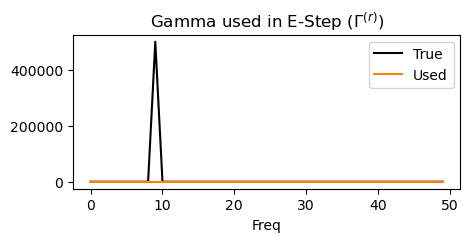

In [86]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(gamma_full[nz,k,k].real, color='k', label='True')
gamma_use = jnp.linalg.inv(gamma_inv_use[nz,:,:])
ax.plot(gamma_use[:,k,k].real, color='tab:orange', label='Used')
ax.set_title('Gamma used in E-Step ($\Gamma^{(r)}$)')
ax.set_xlabel('Freq')
ax.legend()

In [ ]:
L = 25
ov1 = 1
ov2 = -3
obs_var = ov1 * 10**ov2

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

params_jax = {'freqs': freqs, 'nonzero_inds': nz}
params_old = {'Wv': Wv, 'nonzero_inds': nz}

In [227]:
gamma_inv_use = gamma_inv_true
trials_use = jnp.array([0, 1, 2, 3, 4])
jax_exp = JvOExp(obs[:,:,trials_use], gamma_inv_use, obs_var, params_jax, 'jax', track=True)
old_exp = JvOExp(obs[:,:,trials_use], gamma_inv_use, obs_var, params_old, 'old', track=True)
jax_exp.e_step(10)
old_exp.e_step(10)

100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


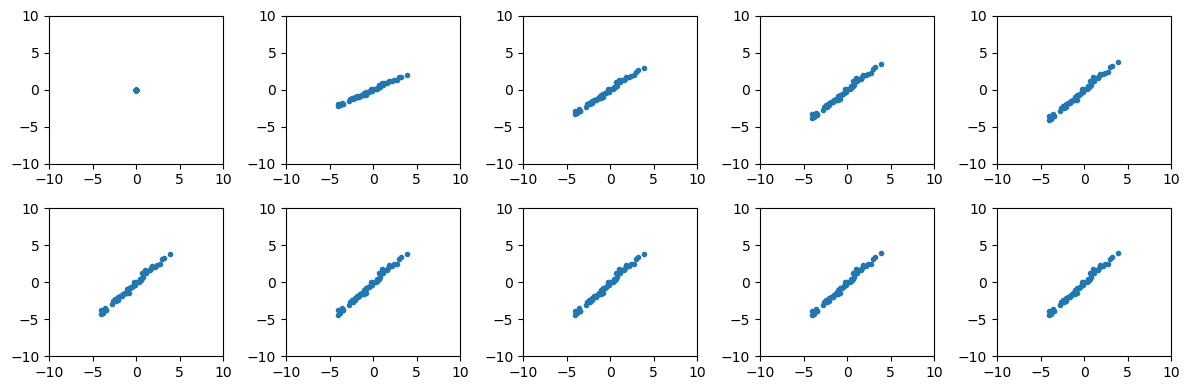

In [242]:
plim = 10
trial = 4
num_iters = len(jax_exp.track_data[trial].track_cost)
colors = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))

k = 0
num_rows = 2
num_cols = 5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,4))
for r, c in enumerate(colors):
    i = jnp.floor((r) / num_cols).astype(int)
    j = r % num_cols
    jax_r = jax_exp.track_data[trial].track_zs[r]
    old_r = old_exp.track_data[trial].track_zs[r]
    ax[i,j].plot(jax_r[:,k].real, old_r[:,k].real, '.', color='tab:blue')
    # ax[i,j].plot(jax_r.imag, old_r.imag, '.', color='tab:blue')
    ax[i,j].set_xlim([-plim,plim])
    ax[i,j].set_ylim([-plim,plim])
plt.tight_layout()

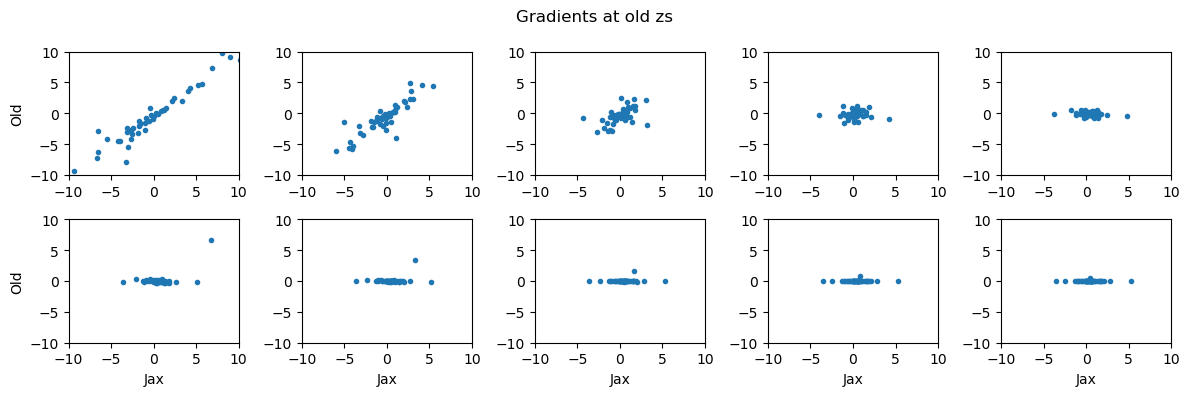

In [245]:
plim = 10
num_iters = len(jax_exp.track_data[trial].track_cost)
colors = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))

num_rows = 2
num_cols = 5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,4))
for r, c in enumerate(colors):
    i = jnp.floor((r) / num_cols).astype(int)
    j = r % num_cols
    zs_use = old_exp.track_data[trial].track_zs[r]
    # old_r = old_exp.track_data[trial].track_grad[r]
    _, jax_r, _ = jax_exp.eval_cost(trial, zs_use)
    _, old_r, _ = old_exp.eval_cost(trial, zs_use)
    # ax[i,j].plot(jax_r[:,k].real, old_r[:,k].real, '.', color='tab:blue')
    ax[i,j].plot(jax_r[:,k].imag, old_r[:,k].imag, '.', color='tab:blue')
    ax[i,j].set_xlim([-plim,plim])
    ax[i,j].set_ylim([-plim,plim])
    if i == num_rows - 1:
        ax[i,j].set_xlabel('Jax')
    if j == 0: 
        ax[i,j].set_ylabel('Old')
fig.suptitle('Gradients at old zs')
plt.tight_layout()

 jax cost: 669342.125, old cost: 669342.3125 jax/old: 0.9999997019767761
 jax cost: 167933.859375, old cost: 168017.875 jax/old: 0.9994999766349792
 jax cost: 43064.8828125, old cost: 42783.265625 jax/old: 1.0065823793411255
 jax cost: 12034.6044921875, old cost: 11456.244140625 jax/old: 1.050484299659729
 jax cost: 4364.8916015625, old cost: 3604.85302734375 jax/old: 1.2108376026153564
 jax cost: 2492.88330078125, old cost: 1631.77685546875 jax/old: 1.5277109146118164
 jax cost: 2049.026611328125, old cost: 1134.0633544921875 jax/old: 1.8068008422851562
 jax cost: 1950.88671875, old cost: 1007.8554077148438 jax/old: 1.9356811046600342
 jax cost: 1933.1036376953125, old cost: 975.6202392578125 jax/old: 1.9814099073410034
 jax cost: 1932.1788330078125, old cost: 967.3072509765625 jax/old: 1.9974820613861084


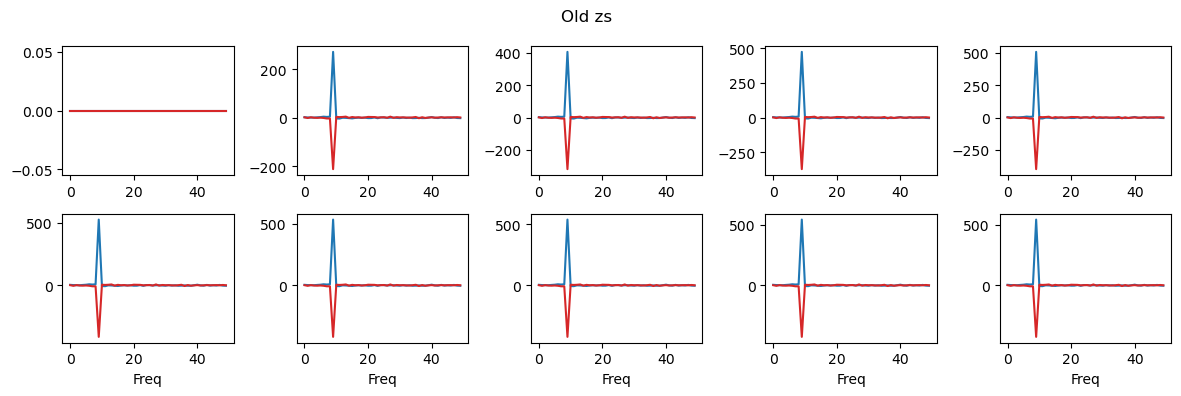

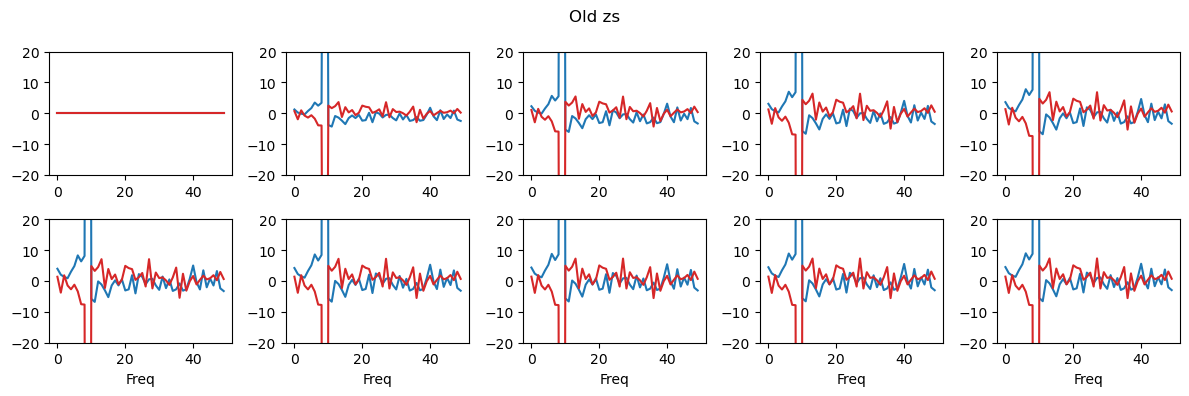

In [257]:
trial = 1
for r in range(num_iters):
    zs_use = old_exp.track_data[trial].track_zs[r]
    # old_r = old_exp.track_data[trial].track_grad[r]
    jax_r, _, _ = jax_exp.eval_cost(trial, zs_use)
    old_r, _, _ = old_exp.eval_cost(trial, zs_use)
    print(f' jax cost: {jax_r.real}, old cost: {old_r.real} jax/old: {jax_r.real / old_r.real}')

num_rows = 2
num_cols = 5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,4))
for r, c in enumerate(colors):
    i = jnp.floor((r) / num_cols).astype(int)
    j = r % num_cols
    zs_use = old_exp.track_data[trial].track_zs[r]
    ax[i,j].plot(zs_use[:,k].real, color='tab:blue')
    ax[i,j].plot(zs_use[:,k].imag, color='tab:red')
    # ax[i,j].set_xlim([-plim,plim])
    # ax[i,j].set_ylim([-plim,plim])
    if i == num_rows - 1:
        ax[i,j].set_xlabel('Freq')
    # if j == 0: 
    #     ax[i,j].set_ylabel('Old')
fig.suptitle('Old zs')
plt.tight_layout()

plim = 20
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,4))
for r, c in enumerate(colors):
    i = jnp.floor((r) / num_cols).astype(int)
    j = r % num_cols
    zs_use = old_exp.track_data[trial].track_zs[r]
    ax[i,j].plot(zs_use[:,k].real, color='tab:blue')
    ax[i,j].plot(zs_use[:,k].imag, color='tab:red')
    ax[i,j].set_ylim([-plim,plim])
    if i == num_rows - 1:
        ax[i,j].set_xlabel('Freq')
    # if j == 0: 
    #     ax[i,j].set_ylabel('Old')
fig.suptitle('Old zs')
plt.tight_layout()

### Aha! 
- there should **not** be a discrepancy in the cost function between the two versions (using the same zs...)
- Investigate this, should be closer line to answer 


Obs var for above is 

In [ ]:
_, jax_r, _ = jax_exp.eval_cost(trial, zs_use)
_, old_r, _ = old_exp.eval_cost(trial, zs_use)

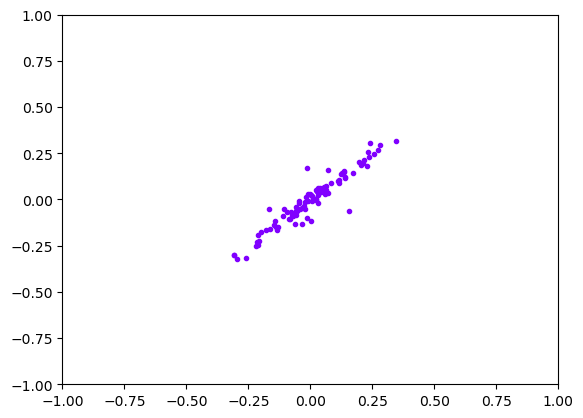

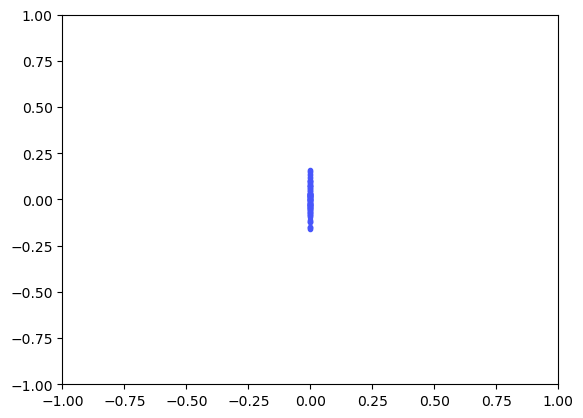

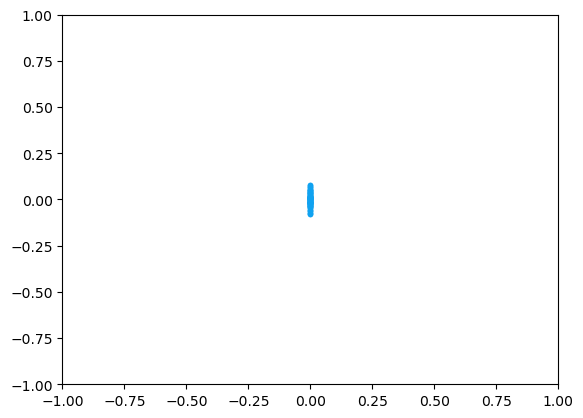

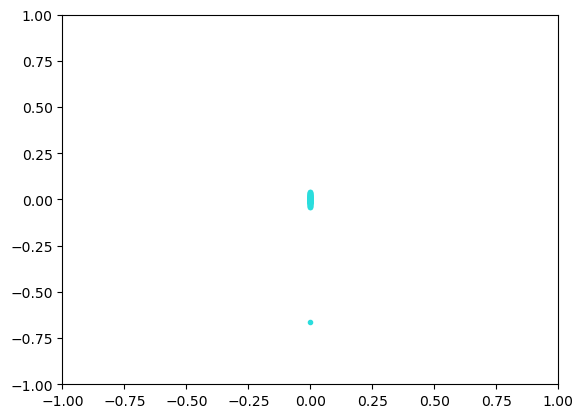

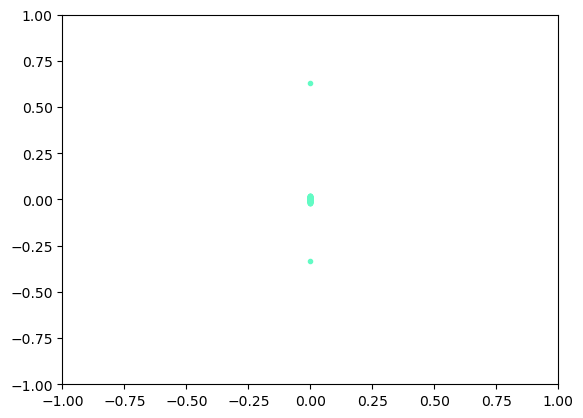

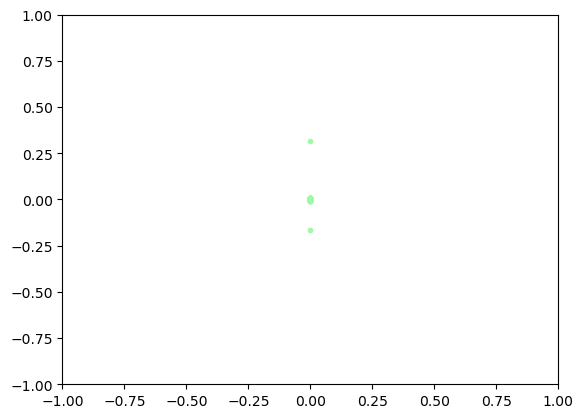

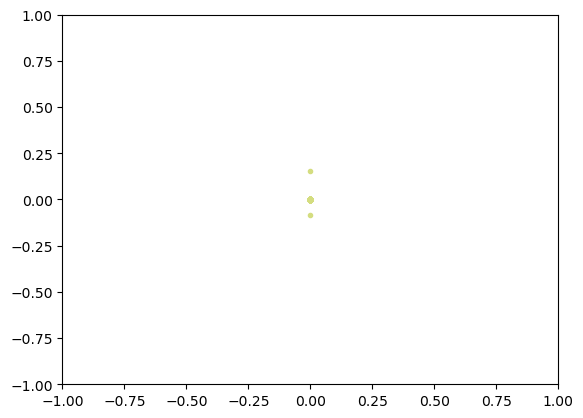

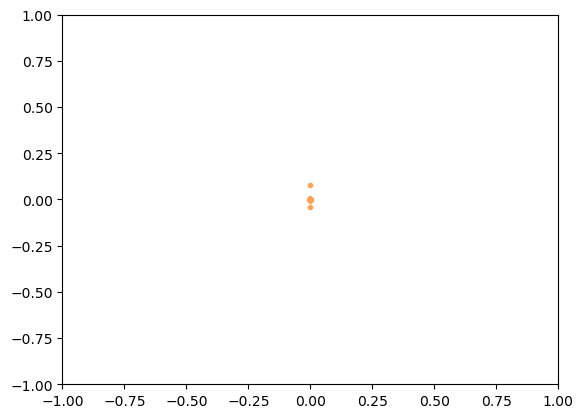

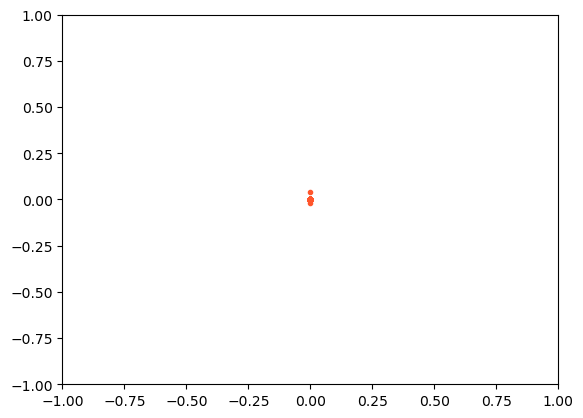

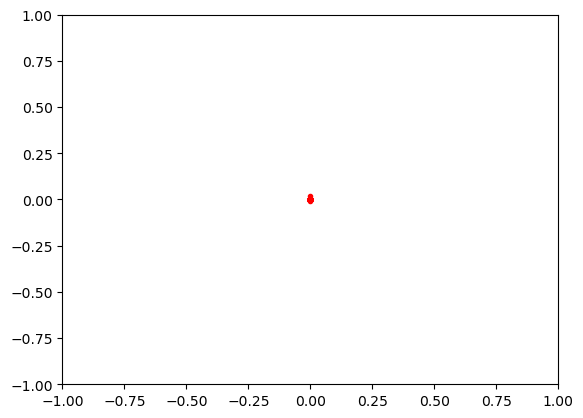

In [161]:
plim = 1
trial = 0
num_iters = len(jax_exp.track_data[trial].track_cost)
colors = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))

for r, c in enumerate(colors):
    fig, ax = plt.subplots()
    jax_r = jax_exp.track_data[trial].track_grad[r]
    old_r = old_exp.track_data[trial].track_grad[r]
    # ax.plot(jax_r.real, old_r.real, '.', color=c)
    ax.plot(jax_r.imag, old_r.imag, '.', color=c)
    ax.set_xlim([-plim,plim])
    ax.set_ylim([-plim,plim])

In [147]:
old_exp.track_data[0].track_cost

[Array(10511.908, dtype=float32),
 Array(3331.4172, dtype=float32),
 Array(1534.3638, dtype=float32),
 Array(1084.3522, dtype=float32),
 Array(971.5879, dtype=float32),
 Array(943.31067, dtype=float32),
 Array(936.21375, dtype=float32),
 Array(934.4315, dtype=float32),
 Array(933.9824, dtype=float32),
 Array(933.86993, dtype=float32)]

In [129]:
old_exp.eval_cost(0)

(Array(10511.908, dtype=float32),
 array([[ 7.06185400e-02+2.12986782e-01j,  1.16885453e-03+6.08231127e-02j],
        [-4.77175117e-02+2.31289148e-01j, -2.45811909e-01-1.38888001e-01j],
        [ 1.08307838e-01+2.46984616e-01j, -8.48852471e-03+1.47280797e-01j],
        [-1.83469318e-02-1.50848255e-01j, -6.82274252e-02+4.39241752e-02j],
        [ 1.53539658e-01-2.28248864e-01j,  4.00785118e-01-2.16343775e-02j],
        [ 2.21947506e-02+2.03751773e-03j, -6.24397248e-02-9.83577594e-03j],
        [-1.55009195e-01+8.80313814e-02j,  7.92865455e-02-5.16276881e-02j],
        [ 2.43512616e-02-1.76619925e-02j,  7.96374679e-02+1.61161661e-01j],
        [ 2.26254895e-01-1.33952141e-01j,  4.06438321e-01+1.72750622e-01j],
        [-3.97630155e-01-5.34587908e+00j,  1.57685804e+01+1.01348543e+01j],
        [ 3.06886658e-02-4.96131480e-02j, -3.33398700e-01-6.26894161e-02j],
        [ 1.64680794e-01+3.03277075e-01j, -6.61853477e-02-1.16496608e-01j],
        [ 9.26456153e-02+2.71601994e-02j,  1.57401755e

In [36]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']

In [48]:
r = 0
temp = conv_mus_old_r2c(old_model_load['track'][0][r]['mus'][trial,:], K=2)

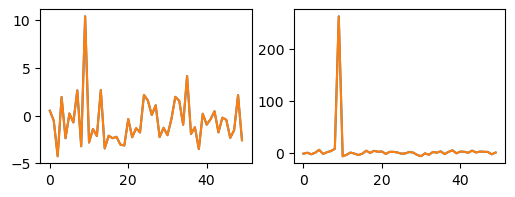

In [58]:
k = 0
fig, ax = plt.subplots(1,2,figsize=(6,2))
# ax[0].plot(temp[:,k].real, mo[:,k].real)
# ax[1].plot(temp[:,k].imag, mo[:,k].imag)
ax[0].plot(temp[:,k].real)
ax[0].plot(mo[:,k].real)

ax[1].plot(temp[:,k].imag)
ax[1].plot(mo[:,k].imag)

In [54]:
# temp[:,k] == mo[:,k]
jnp.isclose(temp[:,k].real, mo[:,k].real)

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [59]:
mo[:,k].real - temp[:,k].real

Array([ 1.47503614e-03,  2.46709585e-03,  6.05106354e-03,  9.11951065e-05,
        4.23836708e-03,  1.74941123e-03,  2.65300274e-03, -5.71250916e-04,
        5.04565239e-03, -8.01372528e-03,  4.66847420e-03,  3.31401825e-03,
        4.00924683e-03, -6.00814819e-04,  5.26332855e-03,  3.97968292e-03,
        4.23240662e-03,  4.09126282e-03,  4.87351418e-03,  4.95862961e-03,
        2.30097771e-03,  4.13537025e-03,  3.22437286e-03,  3.65507603e-03,
       -1.16825104e-04,  4.31776047e-04,  1.89079344e-03,  9.10997391e-04,
        4.11653519e-03,  3.17585468e-03,  3.91960144e-03,  2.30163336e-03,
        6.30617142e-05,  4.62055206e-04,  2.86400318e-03, -2.03227997e-03,
        3.77690792e-03,  3.11553478e-03,  5.30433655e-03,  1.75018609e-03,
        2.85083055e-03,  2.29415298e-03,  1.49798393e-03,  3.62002850e-03,
        2.14344263e-03,  2.35077739e-03,  4.16350365e-03,  3.39329243e-03,
       -1.29222870e-04,  4.40120697e-03], dtype=float32)

In [93]:
j = 5
rnd = 3
print(jnp.round(ho[j,:,:], rnd))
print(jnp.round(hj[j,:,:], rnd))

[[0.39900002+0.j 0.        +0.j]
 [0.        +0.j 0.39900002+0.j]]
[[0.202-0.j 0.   +0.j]
 [0.   +0.j 0.202-0.j]]


In [73]:
jax_output = gj
old_output = go
all_output = jnp.concatenate([jax_output.real, jax_output.imag, old_output.real, old_output.imag])
pltlim = all_output.max() * 1.2
pltlim

Array(5.8509517, dtype=float32)

In [ ]:
j = 5
rnd = 3
print(jnp.round(hess_old[j,:,:], rnd))
print(jnp.round(hess_jax[j,:,:], rnd))

[[0.041+0.j 0.   +0.j]
 [0.   +0.j 0.041+0.j]]
[[0.022-0.j 0.   +0.j]
 [0.   +0.j 0.022-0.j]]


In [87]:
c, g, h = jax_optim.eval_cost(zs_use)
c_old, g_old, h_old = old_optim.eval_cost(zs_use)

In [89]:
jax_optim.run_e_step(zs_use, 5)
jax_optim.zs_est

Array([[-3.2178416e+00-9.75692081e+00j, -4.5411307e-02-2.59950304e+00j],
       [ 2.1790693e+00-1.07292185e+01j,  1.1323582e+01+6.70617485e+00j],
       [-4.9255624e+00-1.16984167e+01j,  7.6103252e-01-6.09524727e+00j],
       [ 8.3638179e-01+6.20769453e+00j,  3.8302755e+00-1.21171963e+00j],
       [-7.0319147e+00+9.75027370e+00j, -1.7253794e+01+2.11686635e+00j],
       [-1.1849945e+00-8.64739478e-01j,  4.3276806e+00+2.09911275e+00j],
       [ 7.0110989e+00-5.32226944e+00j, -8.5392201e-01+4.89689016e+00j],
       [-9.9194247e-01-1.45543385e+00j,  1.5137571e+00-3.24159265e+00j],
       [-1.0569322e+01+1.48338604e+00j, -6.4741259e+00+6.60447061e-01j],
       [ 1.9750397e+01+2.67595154e+02j, -7.9122546e+02-5.07428223e+02j],
       [-9.2914903e-01+7.65042448e+00j, -1.6566336e+00-7.17434502e+00j],
       [-7.3338623e+00-1.10127144e+01j, -6.4931335e+00-1.89818799e-01j],
       [-4.4602318e+00+3.79626483e-01j, -1.4950815e+01+6.78765416e-01j],
       [ 6.9155307e+00+3.91731225e-02j,  6.9660573e

In [90]:
old_optim.run_e_step(zs_use, 5)
old_optim.zs_est

Array([[-3.4465857e+00-1.00879364e+01j, -2.3851075e+00-2.88824463e+00j],
       [ 2.1581862e+00-1.09550066e+01j,  9.3127422e+00+6.56323242e+00j],
       [-5.2316623e+00-1.16986036e+01j, -1.9275222e+00-6.99809694e+00j],
       [ 7.6710922e-01+7.14380169e+00j,  9.0206826e-01-2.11028051e+00j],
       [-7.3739738e+00+1.08095207e+01j, -2.1311638e+01+9.87308145e-01j],
       [-1.1530615e+00-9.77773517e-02j,  6.2840676e-01+4.21033084e-01j],
       [ 7.2398844e+00-4.17092419e+00j, -6.0838895e+00+2.39296269e+00j],
       [-1.2551827e+00+8.34828615e-01j, -6.1001644e+00-7.69287205e+00j],
       [-1.0817959e+01+6.34248209e+00j, -2.1578064e+01-8.24924946e+00j],
       [ 1.9185802e+01+2.59528961e+02j, -7.6791064e+02-4.92093567e+02j],
       [-1.5552982e+00+2.34750509e+00j,  1.3463868e+01+2.88704920e+00j],
       [-7.9015732e+00-1.43666964e+01j,  8.0834174e-01+5.42806244e+00j],
       [-4.4897451e+00-1.28914571e+00j, -9.7808638e+00+4.71501875e+00j],
       [ 7.1904993e+00-1.40069520e+00j,  1.2146281e

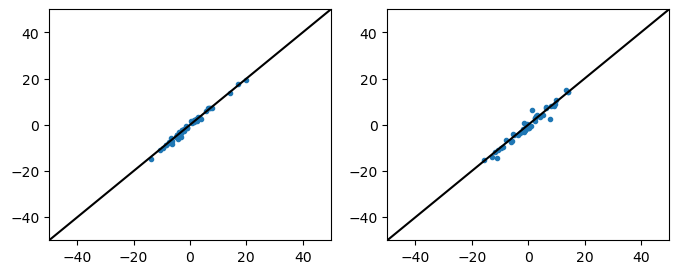

In [93]:
k = 0
pltlim = 50
yxline = jnp.linspace(-pltlim, pltlim, 100)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(jax_optim.zs_est[:,k].real, old_optim.zs_est[:,k].real, '.')
ax[0].set_xlim([-pltlim, pltlim])
ax[0].set_ylim([-pltlim, pltlim])
ax[0].plot(yxline, yxline, 'k')

ax[1].plot(jax_optim.zs_est[:,k].imag, old_optim.zs_est[:,k].imag, '.')
ax[1].set_xlim([-pltlim, pltlim])
ax[1].set_ylim([-pltlim, pltlim])
ax[1].plot(yxline, yxline, 'k')

##### cost/grad/hess on true zs

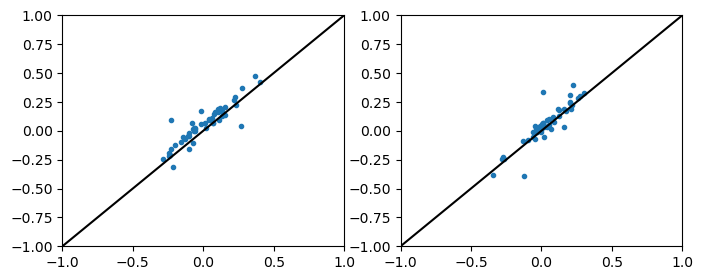

In [49]:
k = 0
pltlim = 1
yxline = jnp.linspace(-pltlim, pltlim, 100)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(grad_jax[:,k].real, grad_old[:,k].real, '.')
ax[0].set_xlim([-pltlim, pltlim])
ax[0].set_ylim([-pltlim, pltlim])
ax[0].plot(yxline, yxline, 'k')

ax[1].plot(grad_jax[:,k].imag, grad_old[:,k].imag, '.')
ax[1].set_xlim([-pltlim, pltlim])
ax[1].set_ylim([-pltlim, pltlim])
ax[1].plot(yxline, yxline, 'k')

In [50]:
j = 5
rnd = 3
print(jnp.round(hess_old[j,:,:], rnd))
print(jnp.round(hess_jax[j,:,:], rnd))

[[0.041+0.j 0.   +0.j]
 [0.   +0.j 0.041+0.j]]
[[0.022-0.j 0.   +0.j]
 [0.   +0.j 0.022-0.j]]


Great, now before cleaning this up, what else will we want to do? 
- different obs var
    - different Gamma (flat, intermediate, true)
        - Look at cost/grad/hess for:
            - different zs
                - 0 init
                - optimized zs

        - Run E-Step and look at:
            - mus
            - cost/grad/hess at mus
        - Run M-Step 
            - Use same set of mus and look at jax vs old

so, let's write:
    - an 'inspect' function for jax / old that takes args (data, obs var, gamma, zs) and returns cost/grad/hess 


##### cost/grad/hess on true zs

In [ ]:
from cohlib.utils import conv_z_to_v, conv_v_to_z
zs_use = zs[nz,:,trial]
vs_use = conv_z_to_v(zs_use, axis=0)

grad_jax = cost_grad_jax(zs_use).conj()
hess_jax = cost_hess_jax(zs_use)
hess_jax_sel = jnp.stack([hess_jax[n,:,n,:] for n in range(Nnz)])

In [ ]:
vs_use_list = jnp.concatenate([vs_use[:,k] for k in range(K)])

grad_old_real = cost_grad_old(vs_use_list)

grad_old = conv_grad_old_r2c(grad_old_real, K)

print(grad_jax[:2,0])
print(grad_old[:2,0])

[ 0.0943716 +0.18769367j -0.06452217+0.25321534j]
[ 0.0938658 +0.18791671j -0.06182092+0.24726279j]


In [ ]:
# data = obs
# track = [gamma_init]
# mus_track = []
# for r in range(20):
#     print(f'EM Iter {r+1}')
#     mus_all, Upss = e_step_par(data, gamma_prev_inv, params, Ups_diag=True, return_mus=True)
#     mus = mus_all[0]
#     mus_outer = mus_all[1]
#     gamma_update = m_step(mus_outer, Upss)

#     gamma_prev_inv_model = jnp.linalg.inv(gamma_update)
#     gamma_prev_inv = jnp.zeros_like(gamma_full)
#     gamma_prev_inv = gamma_prev_inv.at[nz,:,:].set(gamma_prev_inv_model)

#     track.append(gamma_update)
#     mus_track.append(mus)

In [ ]:
# def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
#     if nz is None:
#         nz = jnp.arange(gamma_iter_list[0].shape[0])
#     num_iters = len(gamma_iter_list)
#     color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
#     for r, c in enumerate(color): 
#         gamma_r = gamma_iter_list[r]
#         S_r = gamma_r[nz,k,k].real
#         if dB is True:
#             S_r = 10*jnp.log10(S_r)
#         ax.plot(S_r, color=c, linewidth=2, alpha=0.8)

# dB = True
# fig, ax = plt.subplots()
# S_init = gamma_init[nz,k,k].real
# if dB is True:
#     S_init = 10*jnp.log10(S_init)
# k = 0
# plot_spec_em_iters(ax, track[1:], k, nz, dB=dB)
# ax.plot(S_init, color='tab:grey', linestyle='--')

In [ ]:
### Compare cost/grad/hess on true latent zs vs estimated zs

### Next Steps

1) 

In [ ]:
#

(50, 2, 2)

In [103]:
print(Wv.shape)
print(vs.shape)

(1000, 100)
(100, 2, 50)


In [116]:
xs_old = jnp.einsum('tj,jkl->tkl', Wv_scale, vs)

In [117]:
xs_new = jnp.fft.irfft(zs_0dc, axis=0)
xs_new.shape

(1000, 2, 50)

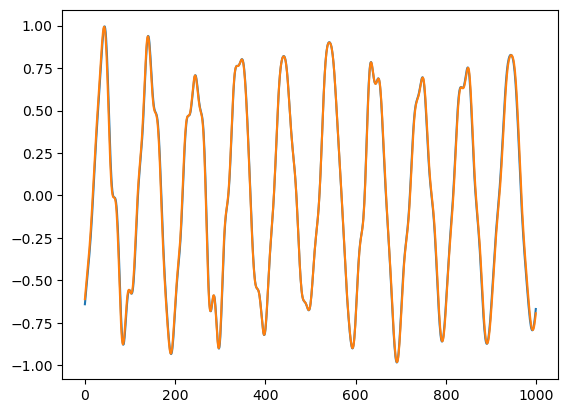

In [120]:
k = 1
l = 1
plt.plot(xs_new[:,k,l])
plt.plot(xs_old[:,k,l])